In [1]:
from core.UserToUser import UserToUser
from core.preprocessing import mean_ratings
from core.preprocessing import normalized_ratings
from core.preprocessing import ids_encoder
from core.preprocessing import train_test_split
from core.preprocessing import rating_matrix
from core.preprocessing import get_examples
from core.preprocessing import scale_ratings

from core.datasets import ml100k
from core.datasets import ml1m

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import sys

In [2]:
def explainable_score(user2user, users, items, theta=0):
    
    def _progress(count):
        sys.stdout.write('\rCompute Explainable score. Progress status : %.1f%%'%(float(count/len(users))*100.0))
        sys.stdout.flush()
    # initialize explainable score to zeros
    W = np.zeros((len(users), len(items)))

    for count, u in enumerate(users):            
        candidate_items = user2user.find_user_candidate_items(u)        
        for i in candidate_items:                
            user_who_rated_i, similar_user_who_rated_i = \
                user2user.similar_users_who_rated_this_item(u, i)
            if user_who_rated_i.shape[0] == 0:
                w = 0.0
            else:
                w = similar_user_who_rated_i.shape[0] / user_who_rated_i.shape[0]
            W[u,i] =  w  if w > theta else 0.0
        _progress(count)
    return W

In [3]:
class ExplainableMatrixFactorization:
    
    def __init__(self, m, n, W, alpha=0.001, beta=0.01, lamb=0.1, k=10):
        """
            - R : Rating matrix of shape (m,n) 
            - W : Explainability Weights of shape (m,n)
            - k : number of latent factors
            - beta : L2 regularization parameter
            - lamb : explainability regularization coefficient
            - theta : threshold above which an item is explainable for a user
        """
        self.W = W
        self.m = m
        self.n = n
        
        np.random.seed(64)
        
        # initialize the latent factor matrices P and Q (of shapes (m,k) and (n,k) respectively) that will be learnt
        self.k = k
        self.P = np.random.normal(size=(self.m,k))
        self.Q = np.random.normal(size=(self.n,k))
        
        # hyperparameter initialization
        self.alpha = alpha
        self.beta = beta
        self.lamb = lamb
        
        # training history
        self.history = {
            "epochs":[],
            "loss":[],
            "val_loss":[],
        }
        
    def print_training_parameters(self):
        print('Training EMF')
        print(f'k={self.k} \t alpha={self.alpha} \t beta={self.beta} \t lambda={self.lamb}')
        
    def update_rule(self, u, i, error):
        self.P[u] = self.P[u] + \
            self.alpha*(2 * error*self.Q[i] - self.beta*self.P[u] - self.lamb*(self.P[u] - self.Q[i]) * self.W[u,i])
        
        self.Q[i] = self.Q[i] + \
            self.alpha*(2 * error*self.P[u] - self.beta*self.Q[i] + self.lamb*(self.P[u] - self.Q[i]) * self.W[u,i])
        
    def mae(self,  x_train, y_train):
        """
        returns the Mean Absolute Error
        """
        # number of training exemples
        M = x_train.shape[0]
        error = 0
        for pair, r in zip(x_train, y_train):
            u, i = pair
            error += np.absolute(r - np.dot(self.P[u], self.Q[i]))
        return error/M
    
    def print_training_progress(self, epoch, epochs, error, val_error, steps=5):
        if epoch == 1 or epoch % steps == 0 :
                print(f"epoch {epoch}/{epochs} - loss : {round(error,3)} - val_loss : {round(val_error,3)}")
                
    def learning_rate_schedule(self, epoch, target_epochs = 20):
        if (epoch >= target_epochs) and (epoch % target_epochs == 0):
                factor = epoch // target_epochs
                self.alpha = self.alpha * (1 / (factor * 20))
                print("\nLearning Rate : {}\n".format(self.alpha))
        
    def fit(self, x_train, y_train, validation_data, epochs=10):
        """
        Train latent factors P and Q according to the training set
        
        :param
            - x_train : training pairs (u,i) for which rating r_ui is known
            - y_train : set of ratings r_ui for all training pairs (u,i)
            - validation_data : tuple (x_test, y_test)
            - epochs : number of time to loop over the entire training set. 
            10 epochs by default
            
        Note that u and i are encoded values of userid and itemid
        """
        self.print_training_parameters()
        
        # get validation data
        x_test, y_test = validation_data
        
        for epoch in range(1, epochs+1):
            for pair, r in zip(x_train, y_train):                
                u,i = pair                
                r_hat = np.dot(self.P[u], self.Q[i])                
                e = r - r_hat
                self.update_rule(u, i, error=e)
                
            # training and validation error  after this epochs
            error = self.mae(x_train, y_train)
            val_error = self.mae(x_test, y_test)
            self.update_history(epoch, error, val_error)            
            self.print_training_progress(epoch, epochs, error, val_error, steps=1)
        
        return self.history
    
    def update_history(self, epoch, error, val_error):
        self.history['epochs'].append(epoch)
        self.history['loss'].append(error)
        self.history['val_loss'].append(val_error)
    
    def evaluate(self, x_test, y_test):
        """
        compute the global error on the test set
        
        :param
            - x_test : test pairs (u,i) for which rating r_ui is known
            - y_test : set of ratings r_ui for all test pairs (u,i)
        """
        error = self.mae(x_test, y_test)
        print(f"validation error : {round(error,3)}")
      
    def predict(self, userid, itemid):
        """
        Make rating prediction for a user on an item

        :param
        - userid
        - itemid

        :return
        - r : predicted rating
        """
        # encode user and item ids to be able to access their latent factors in
        # matrices P and Q
        u = uencoder.transform([userid])[0]
        i = iencoder.transform([itemid])[0]

        # rating prediction using encoded ids. Dot product between P_u and Q_i
        r = np.dot(self.P[u], self.Q[i])

        return r

    def recommend(self, userid, N=30):
        """
        make to N recommendations for a given user

        :return 
        - (top_items,preds) : top N items with the highest predictions 
        """
        # encode the userid
        u = uencoder.transform([userid])[0]

        # predictions for this user on all product
        predictions = np.dot(self.P[u], self.Q.T)

        # get the indices of the top N predictions
        top_idx = np.flip(np.argsort(predictions))[:N]

        # decode indices to get their corresponding itemids
        top_items = iencoder.inverse_transform(top_idx)

        # take corresponding predictions for top N indices
        preds = predictions[top_idx]

        return top_items, preds     

In [4]:
epochs = 10

# Evaluating for MovieLens 100K dataset

## Evaluation on raw ratings

In [5]:
# load data
ratings, movies = ml100k.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

users = sorted(ratings.userid.unique())
items = sorted(ratings.itemid.unique())

m = len(users)
n = len(items)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [6]:
# create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

# compute explainable score
W = explainable_score(usertouser, users, items)

Normalize users ratings ...
Initialize the similarity model ...
Compute nearest neighbors ...


D:\Recommendation System\core\UserToUser.py:41: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.crosstab(self.ratings.userid, self.ratings.itemid, self.ratings.rating, aggfunc=sum).fillna(0).values


User to user recommendation model created with success ...
Compute Explainable score. Progress status : 99.9%

In [7]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

history = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.01 	 beta=0.4 	 lambda=0.01
epoch 1/10 - loss : 0.922 - val_loss : 1.036
epoch 2/10 - loss : 0.79 - val_loss : 0.873
epoch 3/10 - loss : 0.766 - val_loss : 0.837
epoch 4/10 - loss : 0.757 - val_loss : 0.822
epoch 5/10 - loss : 0.753 - val_loss : 0.814
epoch 6/10 - loss : 0.751 - val_loss : 0.808
epoch 7/10 - loss : 0.749 - val_loss : 0.805
epoch 8/10 - loss : 0.748 - val_loss : 0.802
epoch 9/10 - loss : 0.746 - val_loss : 0.799
epoch 10/10 - loss : 0.745 - val_loss : 0.797


## Evaluating on normalized ratings

In [8]:
# load data
ratings, movies = ml100k.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

users = sorted(ratings.userid.unique())
items = sorted(ratings.itemid.unique())

m = len(users)
n = len(items)

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [9]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.022, beta=0.65, lamb=0.01, k=10)

history_1 = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.022 	 beta=0.65 	 lambda=0.01
epoch 1/10 - loss : 0.809 - val_loss : 0.842
epoch 2/10 - loss : 0.809 - val_loss : 0.829
epoch 3/10 - loss : 0.807 - val_loss : 0.821
epoch 4/10 - loss : 0.799 - val_loss : 0.811
epoch 5/10 - loss : 0.789 - val_loss : 0.8
epoch 6/10 - loss : 0.782 - val_loss : 0.793
epoch 7/10 - loss : 0.778 - val_loss : 0.789
epoch 8/10 - loss : 0.776 - val_loss : 0.786
epoch 9/10 - loss : 0.774 - val_loss : 0.784
epoch 10/10 - loss : 0.773 - val_loss : 0.783


# Evaluating for MovieLens 1M dataset

## Evaluating on raw ratings

In [10]:
# load data
ratings, movies = ml1m.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

users = sorted(ratings.userid.unique())
items = sorted(ratings.itemid.unique())

m = len(users)
n = len(items)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [11]:
# create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

# compute explainable score
W = explainable_score(usertouser, users, items)

Normalize users ratings ...


D:\Recommendation System\core\UserToUser.py:41: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.crosstab(self.ratings.userid, self.ratings.itemid, self.ratings.rating, aggfunc=sum).fillna(0).values


Initialize the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Compute Explainable score. Progress status : 100.0%

In [15]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

history_2 = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.01 	 beta=0.4 	 lambda=0.01
epoch 1/10 - loss : 0.821 - val_loss : 0.838
epoch 2/10 - loss : 0.795 - val_loss : 0.808
epoch 3/10 - loss : 0.756 - val_loss : 0.768
epoch 4/10 - loss : 0.742 - val_loss : 0.752
epoch 5/10 - loss : 0.736 - val_loss : 0.745
epoch 6/10 - loss : 0.733 - val_loss : 0.742
epoch 7/10 - loss : 0.732 - val_loss : 0.74
epoch 8/10 - loss : 0.732 - val_loss : 0.739
epoch 9/10 - loss : 0.731 - val_loss : 0.738
epoch 10/10 - loss : 0.731 - val_loss : 0.738


## Evaluation on Normalized Ratings

In [16]:
# load data
ratings, movies = ml1m.load()

# encode users and items ids
ratings, uencoder, iencoder = ids_encoder(ratings)

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

In [17]:
# initialize the model
EMF = ExplainableMatrixFactorization(m, n, W, alpha=0.023, beta=0.59, lamb=0.01, k=10)

history_3 = EMF.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Training EMF
k=10 	 alpha=0.023 	 beta=0.59 	 lambda=0.01
epoch 1/10 - loss : 0.805 - val_loss : 0.814
epoch 2/10 - loss : 0.764 - val_loss : 0.77
epoch 3/10 - loss : 0.756 - val_loss : 0.762
epoch 4/10 - loss : 0.755 - val_loss : 0.759
epoch 5/10 - loss : 0.754 - val_loss : 0.759
epoch 6/10 - loss : 0.754 - val_loss : 0.758
epoch 7/10 - loss : 0.754 - val_loss : 0.758
epoch 8/10 - loss : 0.753 - val_loss : 0.758
epoch 9/10 - loss : 0.753 - val_loss : 0.758
epoch 10/10 - loss : 0.753 - val_loss : 0.758


# Visualization of Results

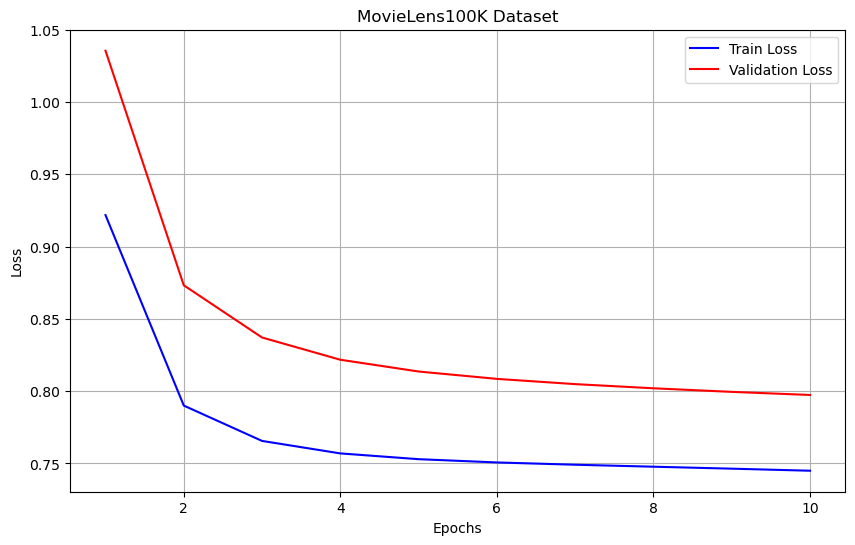

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(history["epochs"], history["loss"], label='Train Loss', color='blue', linestyle='-')
plt.plot(history["epochs"], history["val_loss"], label='Validation Loss', color='red', linestyle='-')

plt.title('MovieLens100K Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("plot-movielens-100k.png")
plt.show()

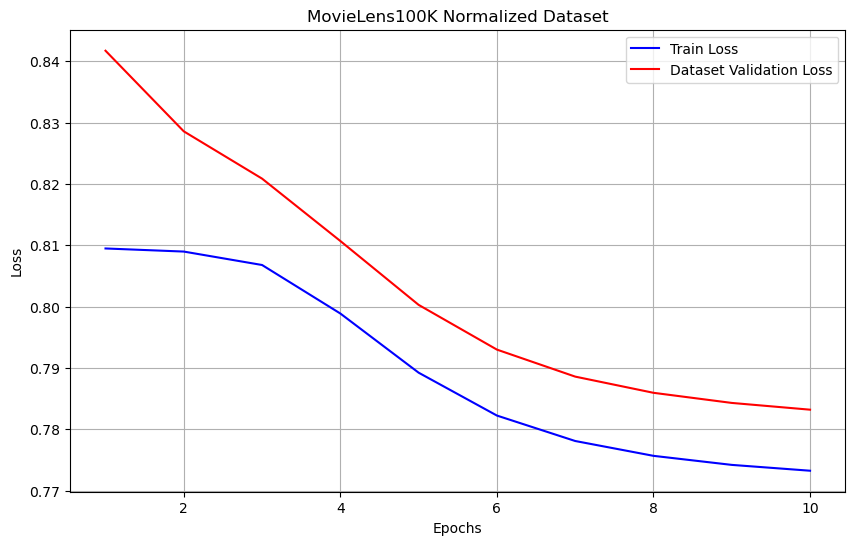

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(history_1["epochs"], history_1["loss"], label='Train Loss', color='blue', linestyle='-')
plt.plot(history_1["epochs"], history_1["val_loss"], label='Dataset Validation Loss', color='red', linestyle='-')

plt.title('MovieLens100K Normalized Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("plot-movielens-100k-normalized.png")
plt.show()

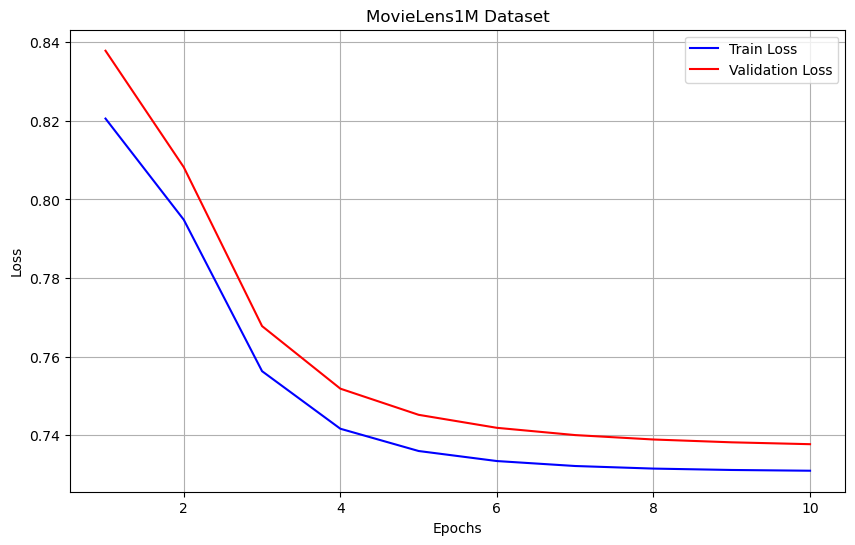

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(history_2["epochs"], history_2["loss"], label='Train Loss', color='blue', linestyle='-')
plt.plot(history_2["epochs"], history_2["val_loss"], label='Validation Loss', color='red', linestyle='-')

plt.title('MovieLens1M Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("plot-movielens-1m.png")
plt.show()

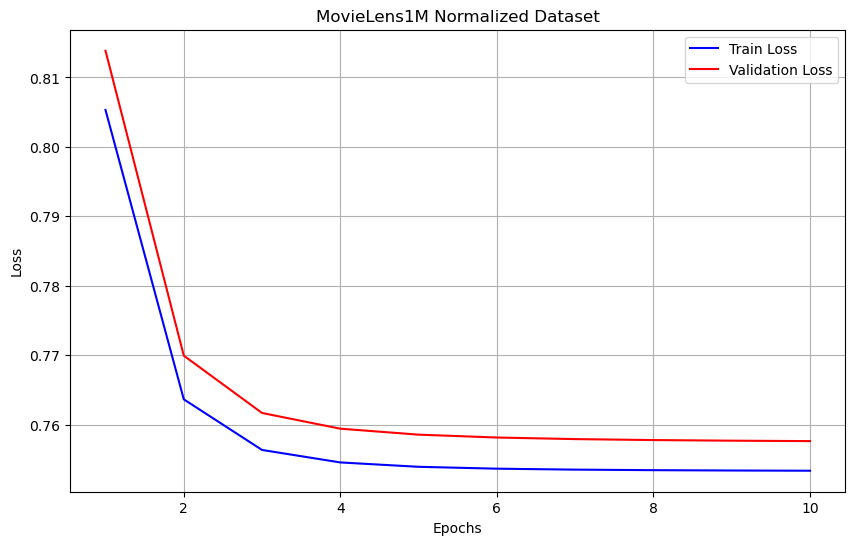

In [44]:
plt.figure(figsize=(10, 6))

plt.plot(history_3["epochs"], history_3["loss"], label='Train Loss', color='blue', linestyle='-')
plt.plot(history_3["epochs"], history_3["val_loss"], label='Validation Loss', color='red', linestyle='-')

plt.title('MovieLens1M Normalized Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("plot-movielens-1m-normalized.png")
plt.show()